### Importing libs

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import linear_model
import networkx as nx

# Question 1: Propensity score matching

## Loading the data
We load the data from the provided csv file. We observe that the categorical variables are encoded using dummy varibales, i.e. binary variables. We are going to stick with this encoding as it is advantegous for the regression task that we are going to perform later.

In [3]:
lalonde_data = pd.read_csv("lalonde.csv")
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [4]:
lalonde_data.dtypes

id           object
treat         int64
age           int64
educ          int64
black         int64
hispan        int64
married       int64
nodegree      int64
re74        float64
re75        float64
re78        float64
dtype: object

## 1. A naive analysis

To begin with, we compare the distribution of the outcome variable (re78) between the two groups in a naive way, that is we ignore the other features in this analysis.

We use the following methods for the comparison:

A. plots:
1. boxplots
2. histograms
3. QQ plots

B. numbers:
1. summary of descriptive statistics
2. ------ test ----- TODO

As all the parts of the analysis of numerical features  also in the subsequent tasks will be based on this methods we define helping functions encapsulating this functionality:

In [5]:
treat = {0: 'treated', 1: 'control'}

def draw_box(df, col):
    """Draw a box plot for the values of the specified column for each of the two groups"""
    df.boxplot(by='treat', column=col, figsize = [10, 7])

def draw_hist(df, col):
    """Draw histograms and kernel density estimation plots for the specified column.
    Two plots are created for the two groups but displayed in two overlapping layers for comparison.
    """
    fig_hist, axs_hist = plt.subplots(nrows=2)
    df.groupby("treat")[col].plot(kind='kde', ax=axs_hist[1])
    axs_hist[1].set_xlabel(col)
    groups = df.groupby("treat")[col]
    for k, v in groups:
        v.hist(label=treat[k], alpha=.75, ax=axs_hist[0], bins=15, range=[df[col].min(), df[col].max()], figsize = [10, 7])
    axs_hist[0].legend()
    axs_hist[0].set_ylabel('number of participants')
    

def draw_qqs(df, col):
    """Draw a QQ plot for both groups to find out more about the distribution of the data.
    NB: A comparison to a normal distribution with fitted parameters is performed."""
    fig_qq, axs_qq = plt.subplots(nrows=2, figsize=(10, 20))
    stats.probplot(df[df.treat == 0][col], dist="norm", plot=axs_qq[0])
    axs_qq[0].set_title('Control Group')
    stats.probplot(df[df.treat == 1][col], dist="norm", plot=axs_qq[1])
    axs_qq[1].set_title('Treated Group')
    plt.show()
    
def get_summary(df, col):
    """Print summary statistics for both groups."""
    print('Control group')
    print('================================================')
    print(df[df.treat == 0][col].describe())
    print('Treated group')
    print('================================================')
    print(df[df.treat == 1][col].describe())

def test(df, col):
    """TODO""" #can same test be used everywhere???? better to perform test after interpreting plot????
    # better not to always display all of them but chose????? incrementally
    #TODO use different test - data not normally distributed, willcoxon gives error
    print(stats.ttest_ind(df[df.treat == 0][col], df[df.treat == 1][col]))

Furthermore we define a funciton that invokes all those functions for a numerical feature and prints the output in a structured way.

In [6]:
def analyse_numeric(df, col):    
    """Perform analysis for a numerical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    draw_box(df, col)
    draw_hist(df, col)
    draw_qqs(df, col)
    print()
    get_summary(df, col)
    print()
    test(df, col)
    print()
    print()

Let us now analyse the distribution of the 're78' feature in the two groups. For the interpretation see below.

                                   re78


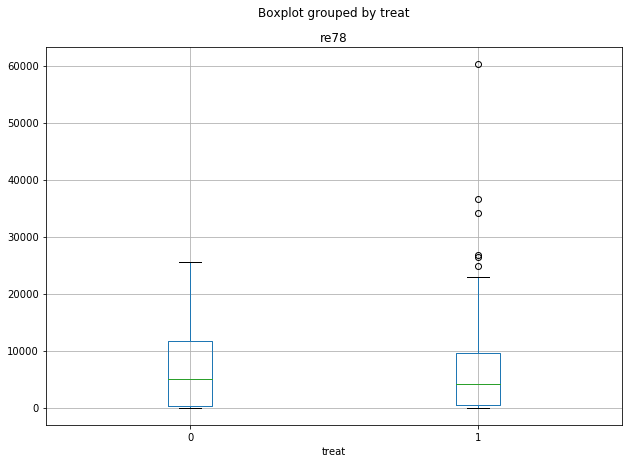

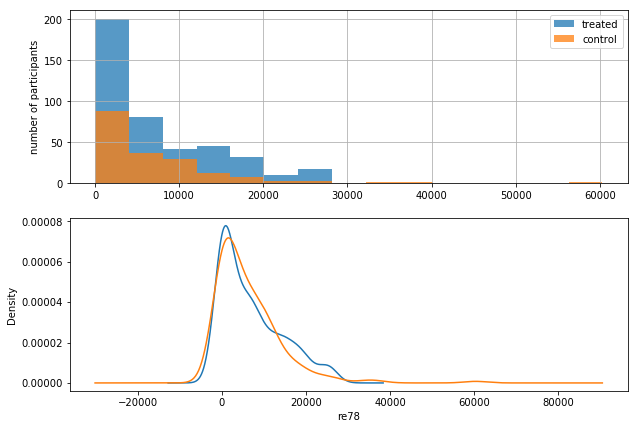

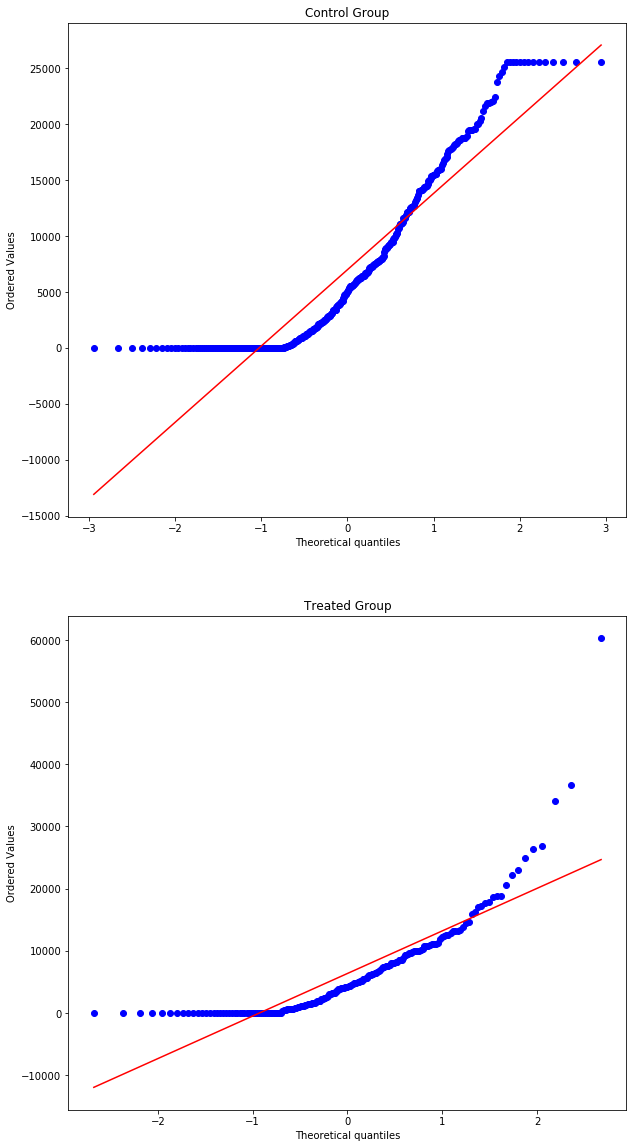


Control group
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64
Treated group
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Ttest_indResult(statistic=0.96635222544637778, pvalue=0.33424966859096539)




In [7]:
analyse_numeric(lalonde_data, 're78')

### **(Naive) Conclusions:** .... TODO...

## 2. A closer look at the data

In order to get a better feeling for whether our naive analysis was appropriate we also compare the distributions of the other covariates. To begin with, we interpret the numerical features in using the same strategy as in Part 1.

### Analysis of numerical columns

                                   age


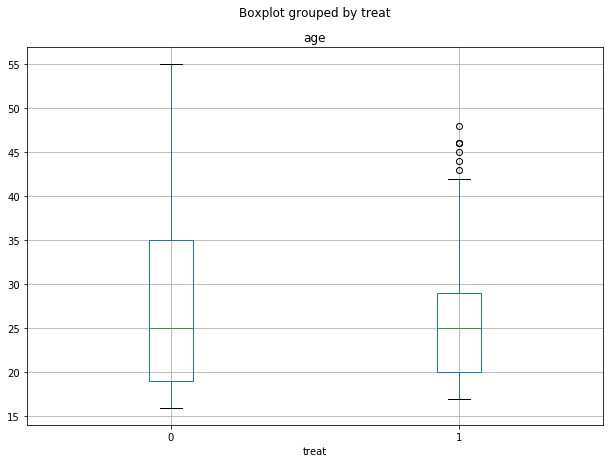

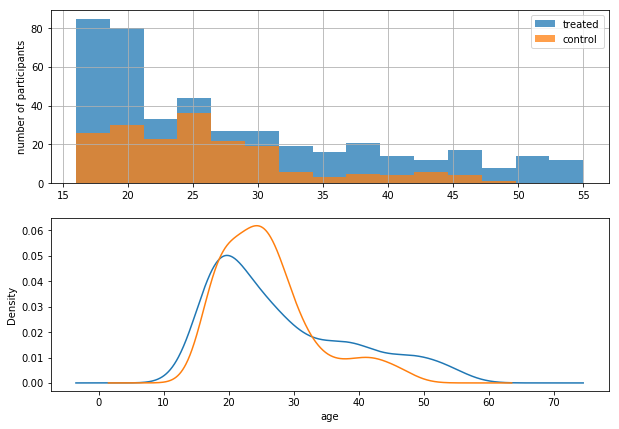

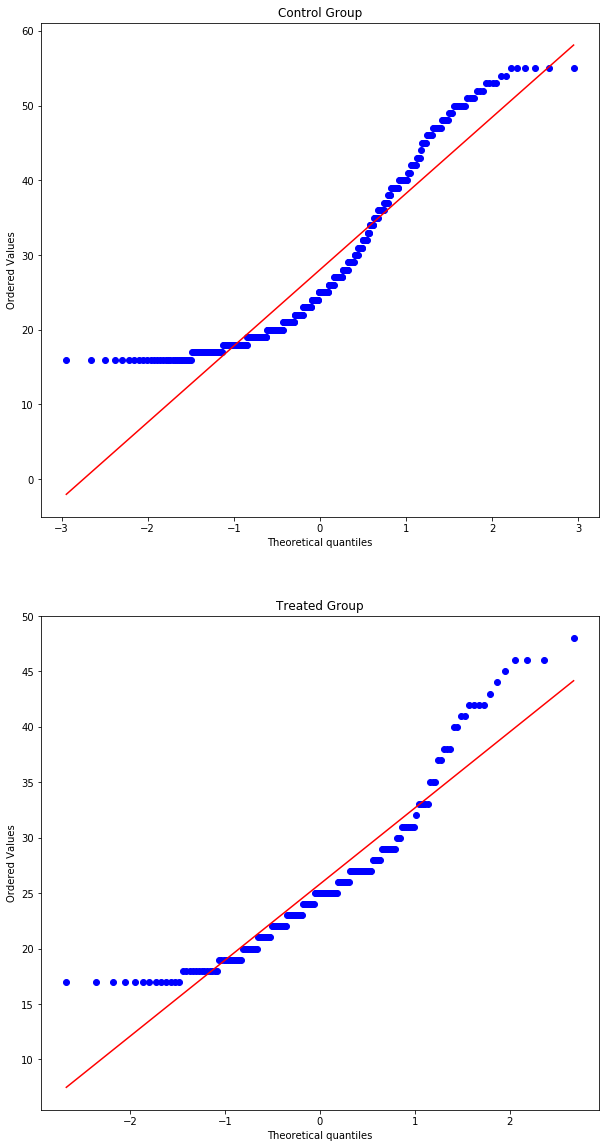


Control group
count    429.000000
mean      28.030303
std       10.786653
min       16.000000
25%       19.000000
50%       25.000000
75%       35.000000
max       55.000000
Name: age, dtype: float64
Treated group
count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

Ttest_indResult(statistic=2.5590130633091519, pvalue=0.010736332582438238)


                                   educ


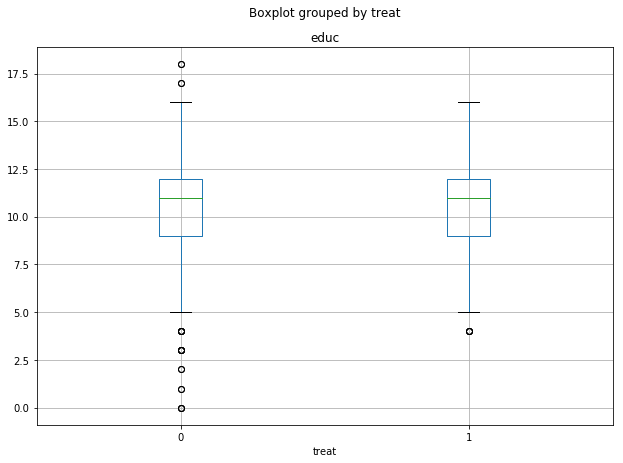

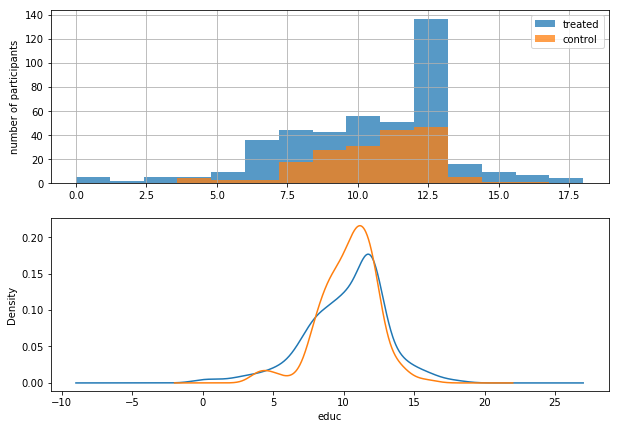

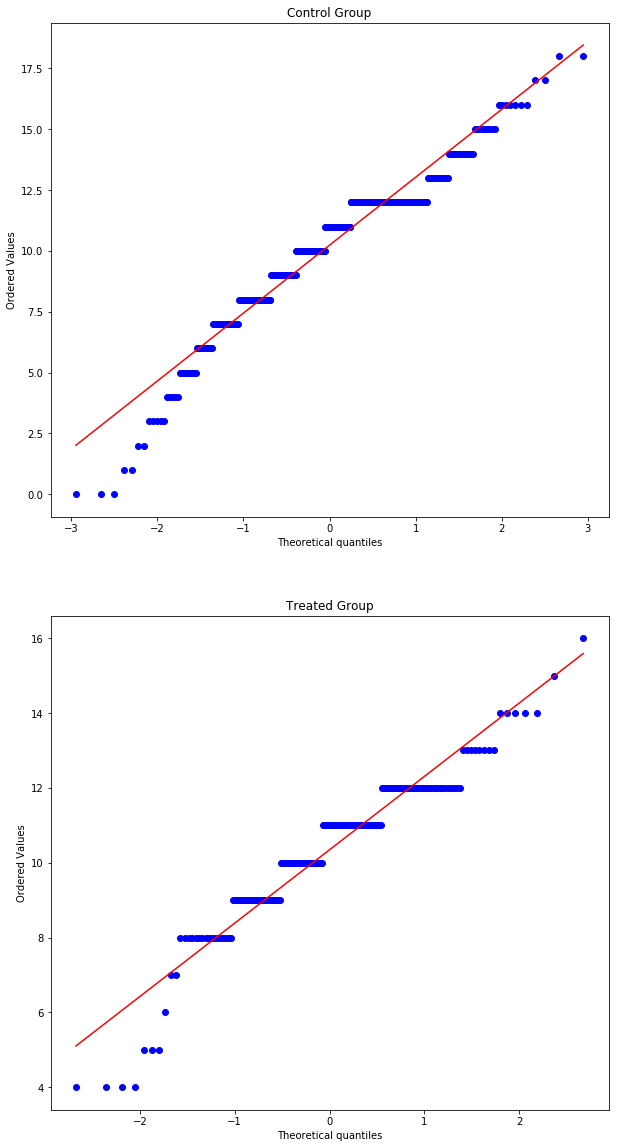


Control group
count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64
Treated group
count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

Ttest_indResult(statistic=-0.47774686042840225, pvalue=0.63300097204734651)


                                   re74


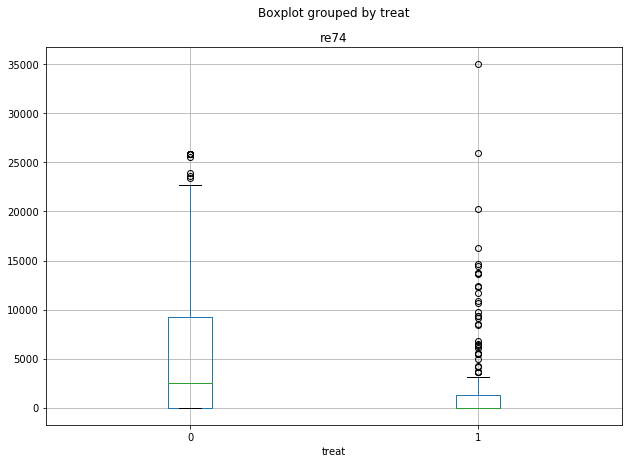

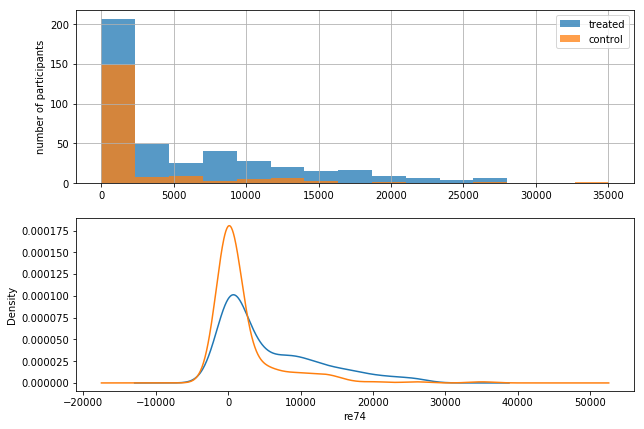

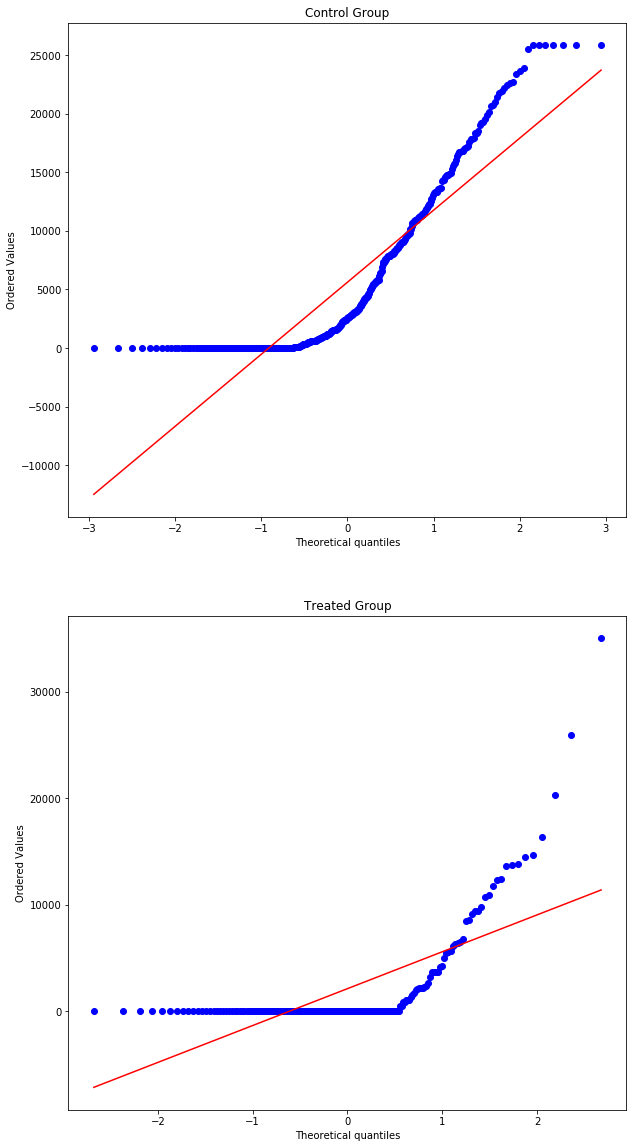


Control group
count      429.000000
mean      5619.236506
std       6788.750796
min          0.000000
25%          0.000000
50%       2547.047000
75%       9277.128000
max      25862.320000
Name: re74, dtype: float64
Treated group
count      185.000000
mean      2095.573689
std       4886.620353
min          0.000000
25%          0.000000
50%          0.000000
75%       1291.468000
max      35040.070000
Name: re74, dtype: float64

Ttest_indResult(statistic=6.3814644855087463, pvalue=3.4645852577576162e-10)


                                   re75


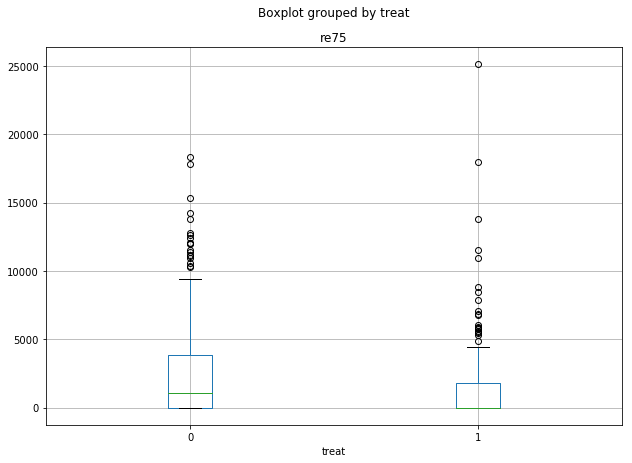

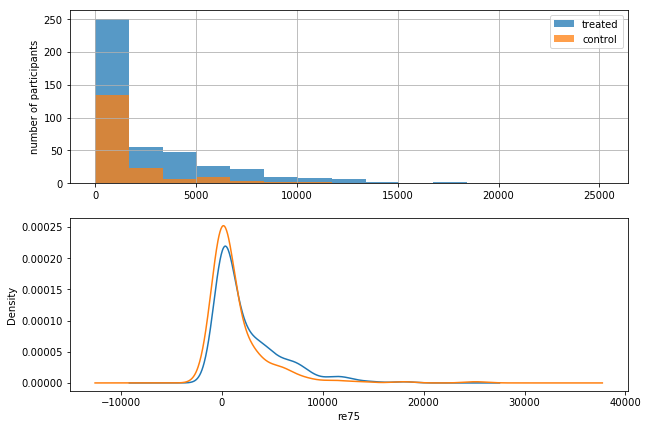

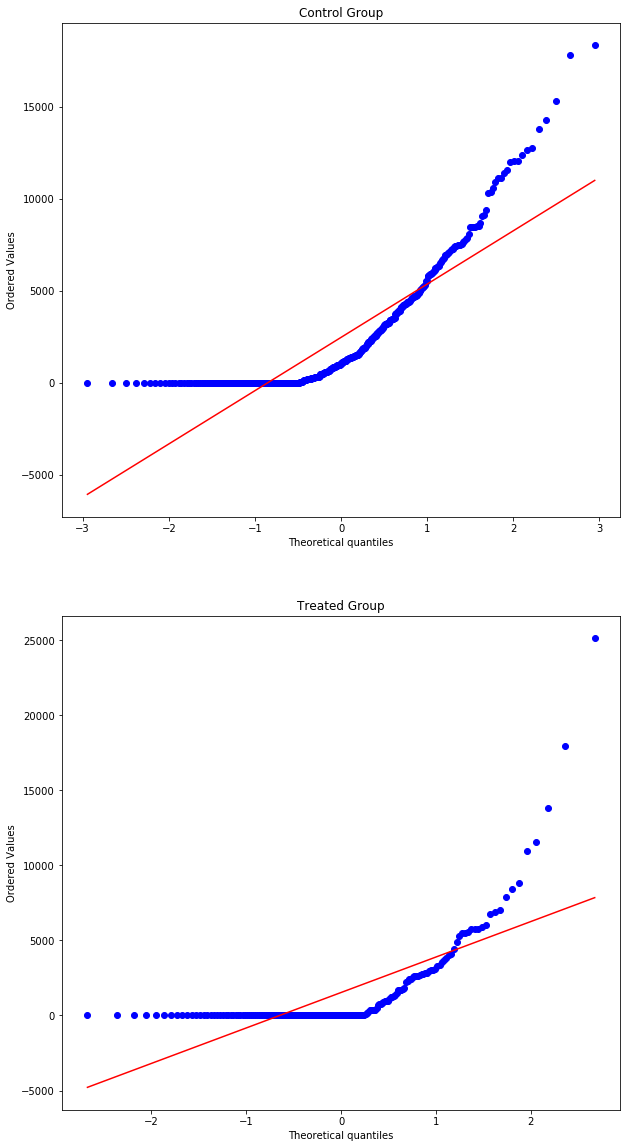


Control group
count      429.000000
mean      2466.484443
std       3291.996183
min          0.000000
25%          0.000000
50%       1086.726000
75%       3881.419000
max      18347.230000
Name: re75, dtype: float64
Treated group
count      185.000000
mean      1532.055314
std       3219.250870
min          0.000000
25%          0.000000
50%          0.000000
75%       1817.284000
max      25142.240000
Name: re75, dtype: float64

Ttest_indResult(statistic=3.2485513845081773, pvalue=0.0012234443948498416)




In [8]:
for col in ['age', 'educ', 're74', 're75']:
    analyse_numeric(lalonde_data, col)

#### **Interpretation:** .... TODO...

### Analysis of categorical columns

It remains to take a closer look at the categorical variables. As the methods used above are not appropriate for categorical variables , we need new functions for the analysis (For example, there is no point in drawing histograms for categrical variables, the thing to use here are bar plots.):

In [9]:
def draw_bar(df, col):
    '''Draw a bar plot of the number of values in each category for the two groups'''
    df_grouped = df.groupby(['treat', col])[col].count()
    df_grouped = df_grouped.unstack()
    pl = df_grouped.plot(kind='bar', figsize=[5,5])
    pl.set_title(col)
    pl.set_ylabel('number of participants')
    pl.set_xlabel('group')
    plt.show()


In [10]:
#TODO add more analysis....

For the race feature some preprocessing is needed in order to be able to draw a meaningful bar plot. Especially, the data frame does not contain a column for white people. We assume that individuals are white in case they are neither black nor hispanic.

In [11]:
def plot_race(df):
    '''Draw a bar plot for the race feature.'''
    df['white'] = (~(df['black'].astype(bool) | df['hispan'].astype(bool))).astype(int)
    race = df[['white', 'black', 'hispan']].stack()
    df.drop('white', 1)
    race = pd.Series(pd.Categorical(race[race!=0].index.get_level_values(1)))
    race_group = pd.concat([df.treat, race], axis=1, keys=['treat', 'race'])
    draw_bar(race_group, 'race')

For the significance test we use Fishers exact test --- TODO justification!

In [12]:
def test_fisher(df, col):
    '''Perform fishers exact test'''
    print('Fisher exact test')
    print('================================================')
    #compute contingency table
    df['neg'] = df[col].apply(lambda x: 1-x)
    table = df.groupby(df.treat)[col, 'neg'].sum()
    df.drop('neg', axis=1)
    #perform test
    print(stats.fisher_exact(table))

In [13]:
def analyse_categoric(df, col=None):    
    """Perform analysis for a categorical feature and pretty print result."""
    print('=================================================================================')
    print('                                  ', col)
    print('=================================================================================')
    if(col == None):
        plot_race(df)
        print()
        print()
    else:
        draw_bar(df, col)
        print()
        get_summary(df, col)
        print()
        test_fisher(df, col)
        print()
        print()

Now we can use those functions for our analysis:

                                   married


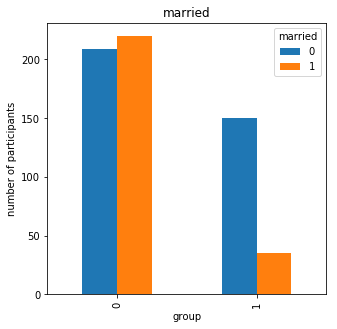


Control group
count    429.000000
mean       0.512821
std        0.500419
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: married, dtype: float64
Treated group
count    185.000000
mean       0.189189
std        0.392722
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: married, dtype: float64

Fisher exact test
(4.511278195488722, 1.6378271542024079e-14)


                                   nodegree


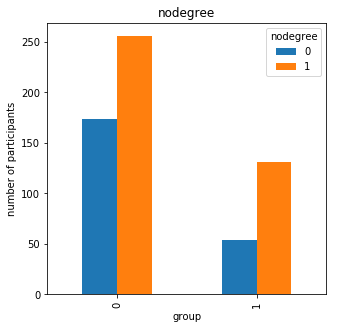


Control group
count    429.000000
mean       0.596737
std        0.491126
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64
Treated group
count    185.000000
mean       0.708108
std        0.455867
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

Fisher exact test
(0.60998102634249662, 0.010620827203367735)


                                   None


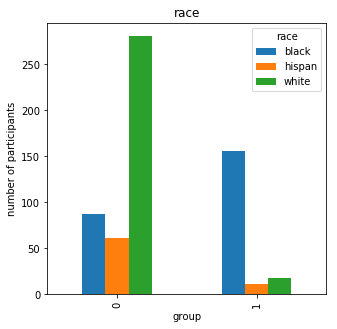

In [14]:
for col in ['married', 'nodegree']: 
    analyse_categoric(lalonde_data, col)

analyse_categoric(lalonde_data)

**Conclusions**:

## 3. A propensity score model

In [15]:
logistic = linear_model.LogisticRegression()

logistic = logistic.fit(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1), lalonde_data.treat)
propensity_scores = logistic.predict_proba(lalonde_data.drop(lalonde_data.columns[[0, 1, -1]], axis=1))

print(logistic.classes_)
print(propensity_scores[:5])

In [16]:
lalonde_data['propensity'] = propensity_scores[:, 1]

## 4. Balancing the dataset via matching

1:1, without replacement
optimal matching

In [17]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1].assign(key=0), lalonde_data.reset_index()[lalonde_data.treat == 0].assign(key=0), on='key').drop('key', axis=1)
#print(graph_data.head())
graph_data['weight'] = 1 - np.abs(graph_data['propensity_x'] - graph_data['propensity_y'])
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

In [18]:
len(matching) == 2 * len(lalonde_data[lalonde_data.treat == 1])

True

In [19]:
#todo remove :-)
for key, value in matching.items():
    if(matching[value]!=key):
        print('sad storry')
print('juhu')

juhu


In [20]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,neg,white,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,0,0.462205
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,0,0.158856
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,0,0.738859
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,0,0.671526
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,0,0.663063


compare outcomes: see 1 and 2 + techniques from paper

treat
0    Axes(0.125,0.536818;0.775x0.343182)
1    Axes(0.125,0.536818;0.775x0.343182)
Name: re78, dtype: object

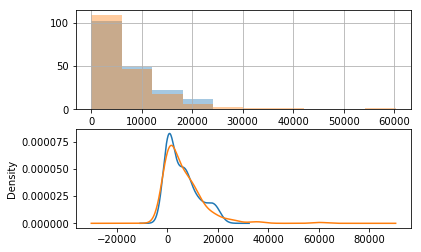

In [21]:
fig, axs = plt.subplots(nrows=2)
lalonde_data_balanced.groupby("treat").re78.plot(kind='kde', ax=axs[1])
lalonde_data_balanced.groupby("treat").re78.hist(alpha=0.4, ax=axs[0], range=[lalonde_data_balanced.re78.min(), lalonde_data_balanced.re78.max()])

## Perform same analysis as in 1 and 2 

                                   age


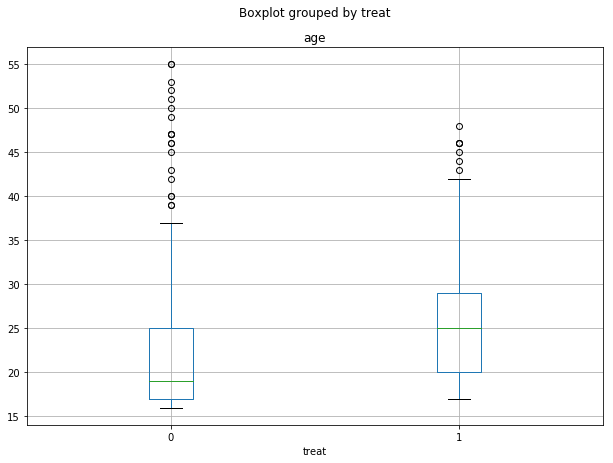

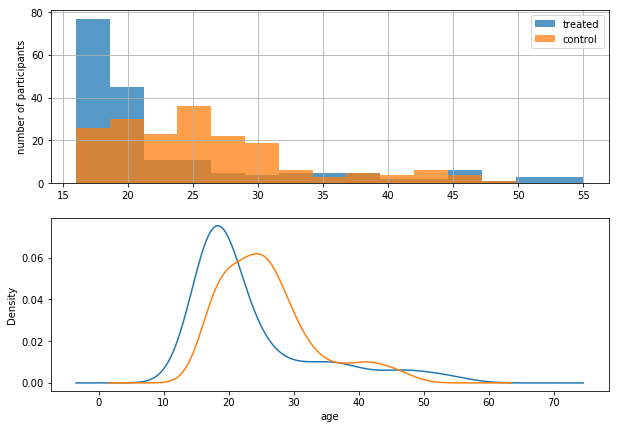

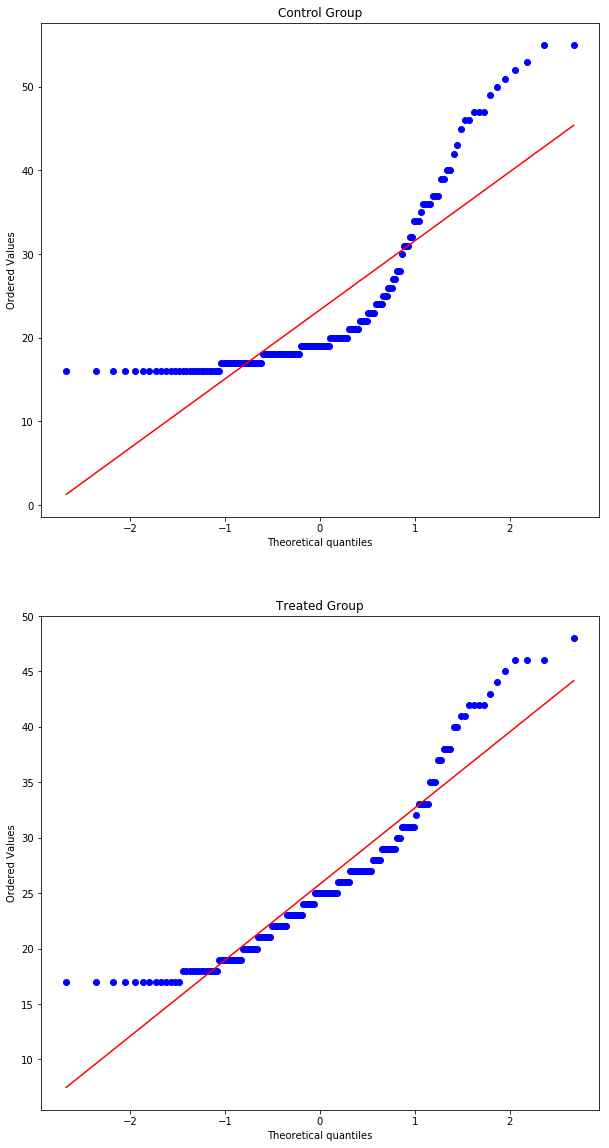


Control group
count    185.000000
mean      23.335135
std        9.544297
min       16.000000
25%       17.000000
50%       19.000000
75%       25.000000
max       55.000000
Name: age, dtype: float64
Treated group
count    185.000000
mean      25.816216
std        7.155019
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

Ttest_indResult(statistic=-2.8290644517145349, pvalue=0.004924165725588318)


                                   educ


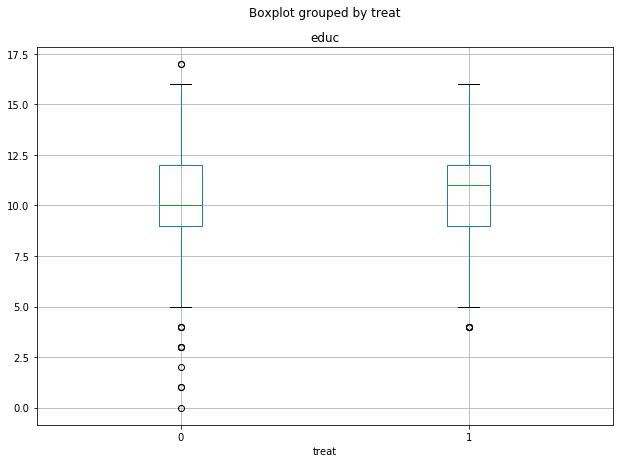

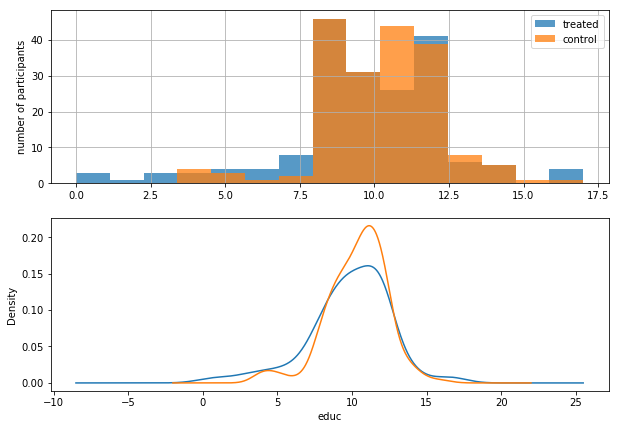

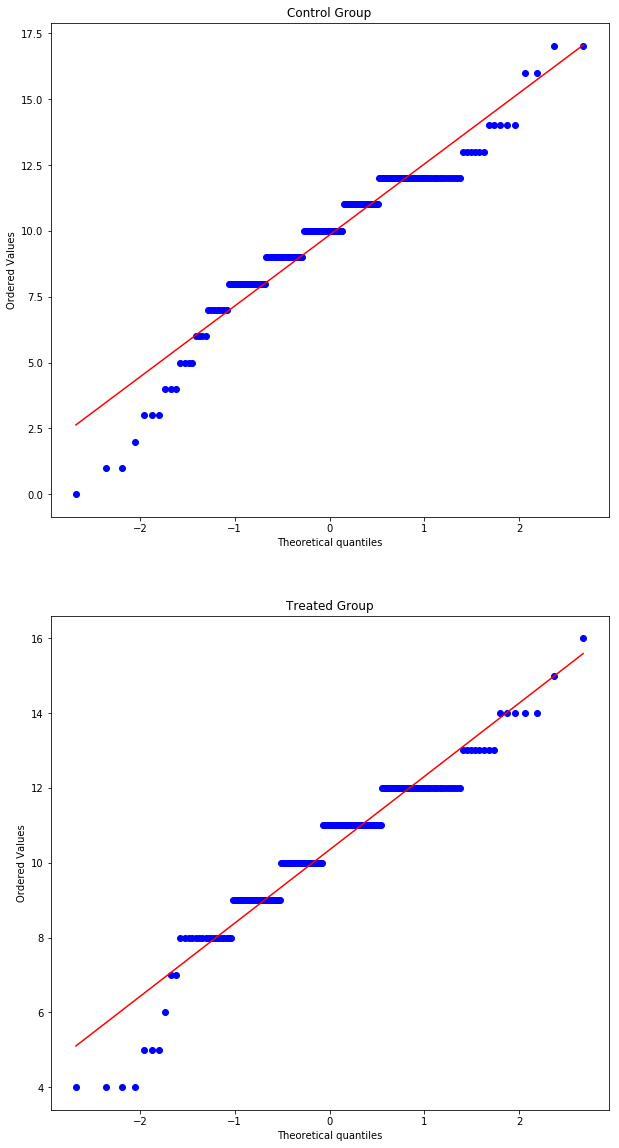


Control group
count    185.000000
mean       9.843243
std        2.770628
min        0.000000
25%        9.000000
50%       10.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64
Treated group
count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

Ttest_indResult(statistic=-1.997331004299409, pvalue=0.046525105002461958)


                                   re74


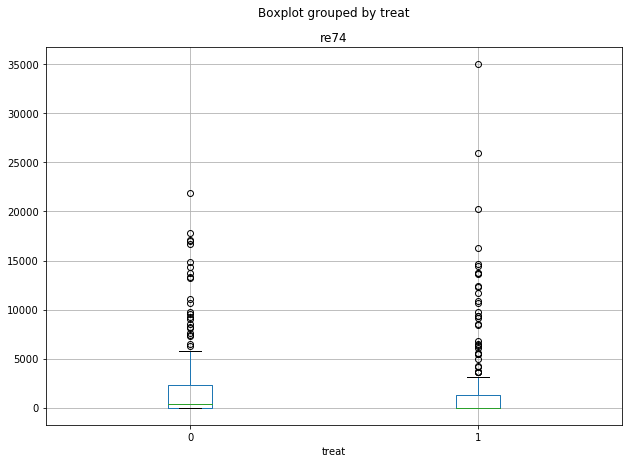

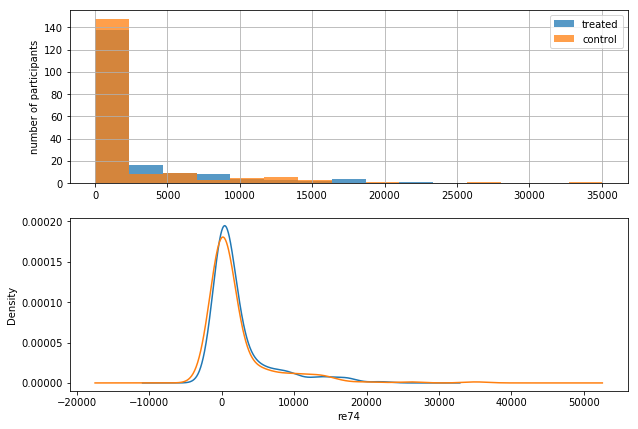

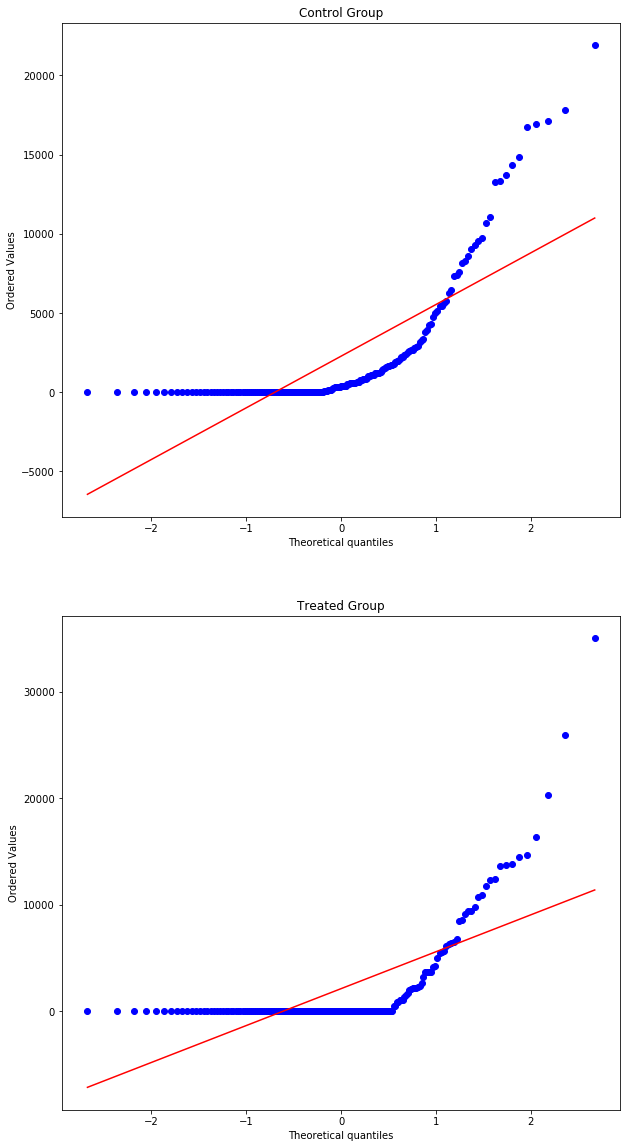


Control group
count      185.000000
mean      2269.159279
std       4135.294200
min          0.000000
25%          0.000000
50%        368.342200
75%       2355.039000
max      21918.320000
Name: re74, dtype: float64
Treated group
count      185.000000
mean      2095.573689
std       4886.620353
min          0.000000
25%          0.000000
50%          0.000000
75%       1291.468000
max      35040.070000
Name: re74, dtype: float64

Ttest_indResult(statistic=0.36882050636264846, pvalue=0.71247361512760476)


                                   re75


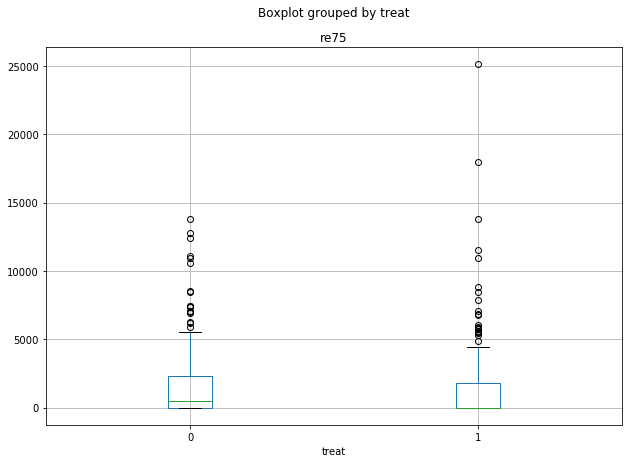

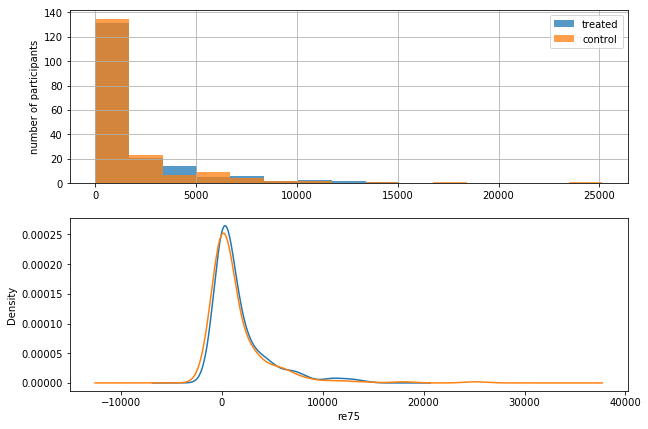

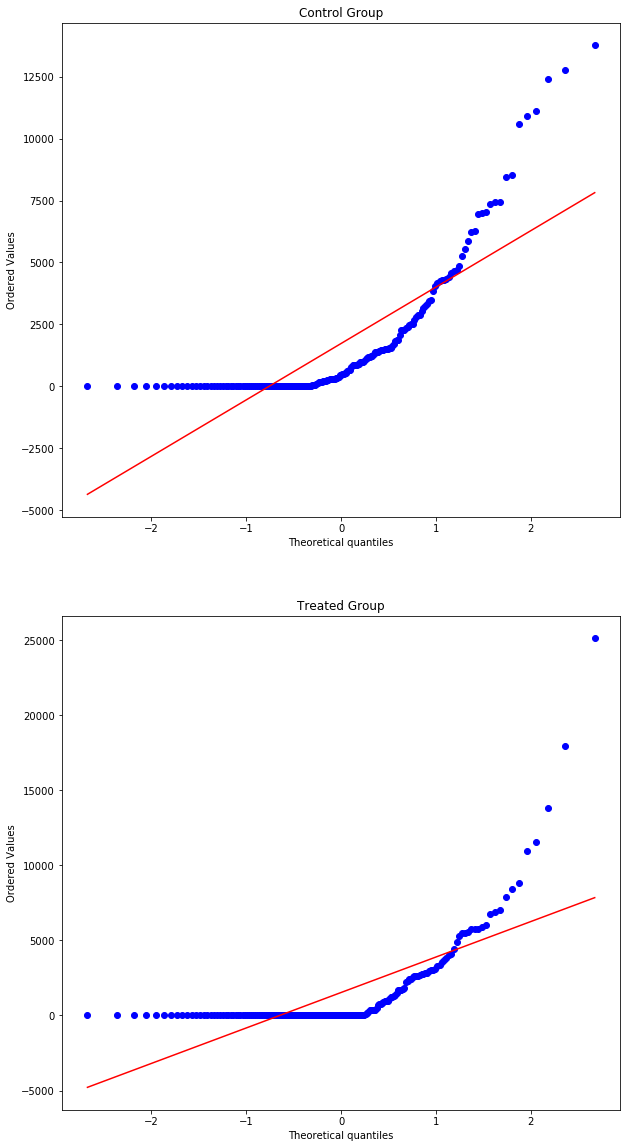


Control group
count      185.000000
mean      1729.470944
std       2735.292194
min          0.000000
25%          0.000000
50%        470.854800
75%       2286.242000
max      13776.530000
Name: re75, dtype: float64
Treated group
count      185.000000
mean      1532.055314
std       3219.250870
min          0.000000
25%          0.000000
50%          0.000000
75%       1817.284000
max      25142.240000
Name: re75, dtype: float64

Ttest_indResult(statistic=0.63562981732239388, pvalue=0.52541279577822997)


                                   re78


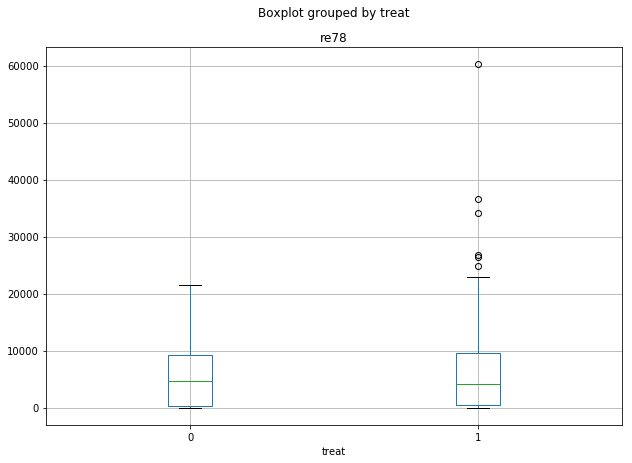

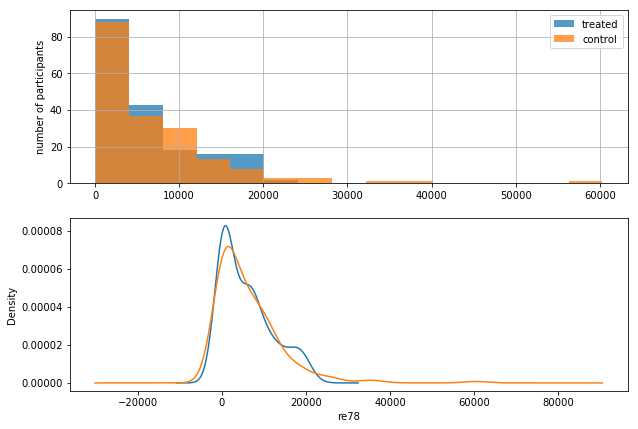

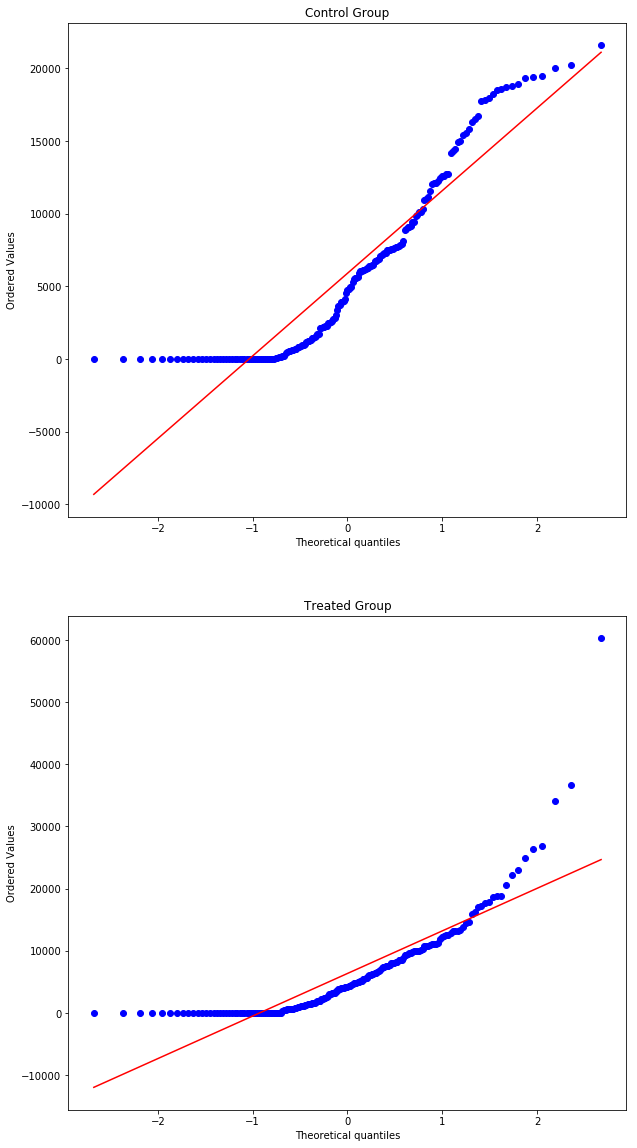


Control group
count      185.000000
mean      5901.145226
std       6032.134409
min          0.000000
25%        237.914000
50%       4728.725000
75%       9166.338000
max      21602.880000
Name: re78, dtype: float64
Treated group
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

Ttest_indResult(statistic=-0.61464418335349214, pvalue=0.5391695664112055)




In [22]:
for col in ['age', 'educ', 're74', 're75', 're78']:
    analyse_numeric(lalonde_data_balanced, col)

                                   married


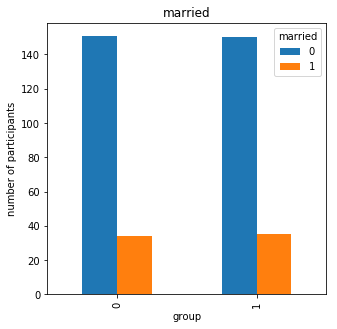


Control group
count    185.000000
mean       0.183784
std        0.388359
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: married, dtype: float64
Treated group
count    185.000000
mean       0.189189
std        0.392722
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: married, dtype: float64

Fisher exact test
(0.96499526963103122, 1.0)


                                   nodegree


/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


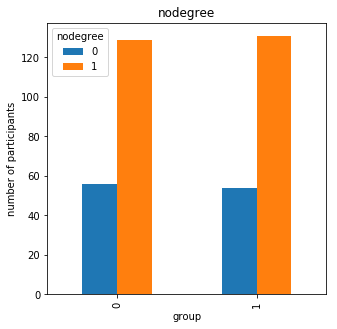


Control group
count    185.000000
mean       0.697297
std        0.460674
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64
Treated group
count    185.000000
mean       0.708108
std        0.455867
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

Fisher exact test
(0.9495637949836423, 0.90947954262192354)


                                   None


/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


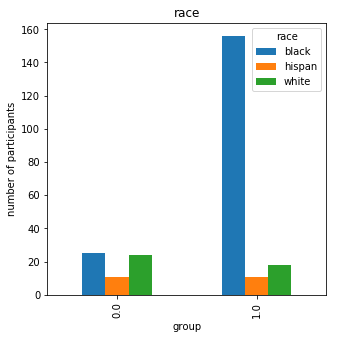

In [23]:
for col in ['married', 'nodegree']: 
    analyse_categoric(lalonde_data_balanced, col)

analyse_categoric(lalonde_data_balanced)

In [24]:
#todo add test for categoric
#it somehow would make more sense for race ro see ratios...

## 5. Balancing the groups further

identify "the problematic feature": if different in this feature: add very high penalty to weight, oder: direkt in join auf equality filtern :P

problenatic features: age, race

Further balance for race:

In [25]:
graph_data = pd.merge(lalonde_data.reset_index()[lalonde_data.treat == 1], lalonde_data.reset_index()[lalonde_data.treat == 0], on='age')
#print(graph_data.head())
graph_data['weight'] = 1 - np.abs(graph_data['propensity_x'] - graph_data['propensity_y'])
G = nx.Graph()
G.add_weighted_edges_from(zip(graph_data.index_x, graph_data.index_y, graph_data.weight))
matching = nx.max_weight_matching(G)

In [26]:
lalonde_data_balanced = lalonde_data.iloc[list(matching.keys())]
lalonde_data_balanced.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,neg,white,propensity
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,0,0.462205
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,0,0.158856
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,0,0.738859
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,0,0.671526
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,0,0.663063


### Analysis

                                   age


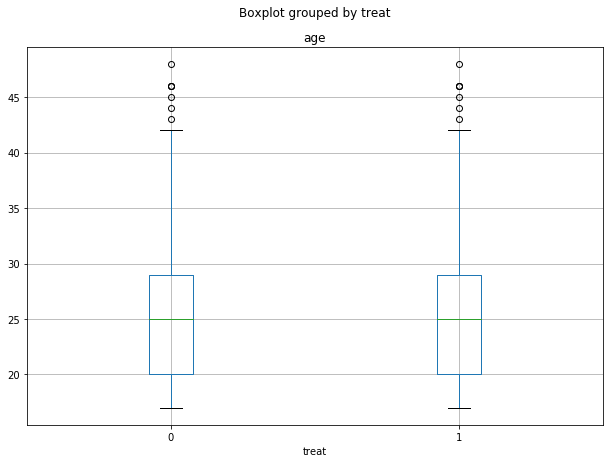

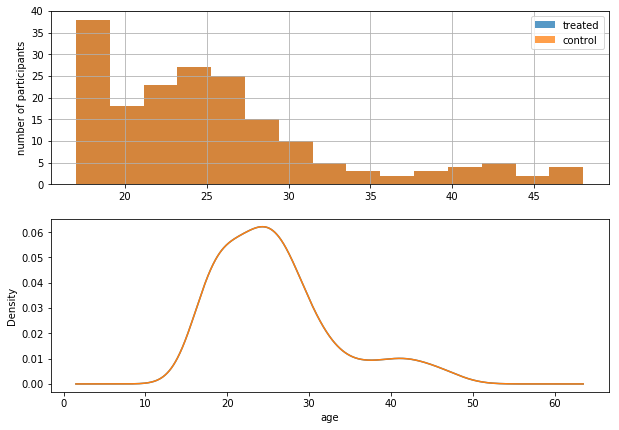

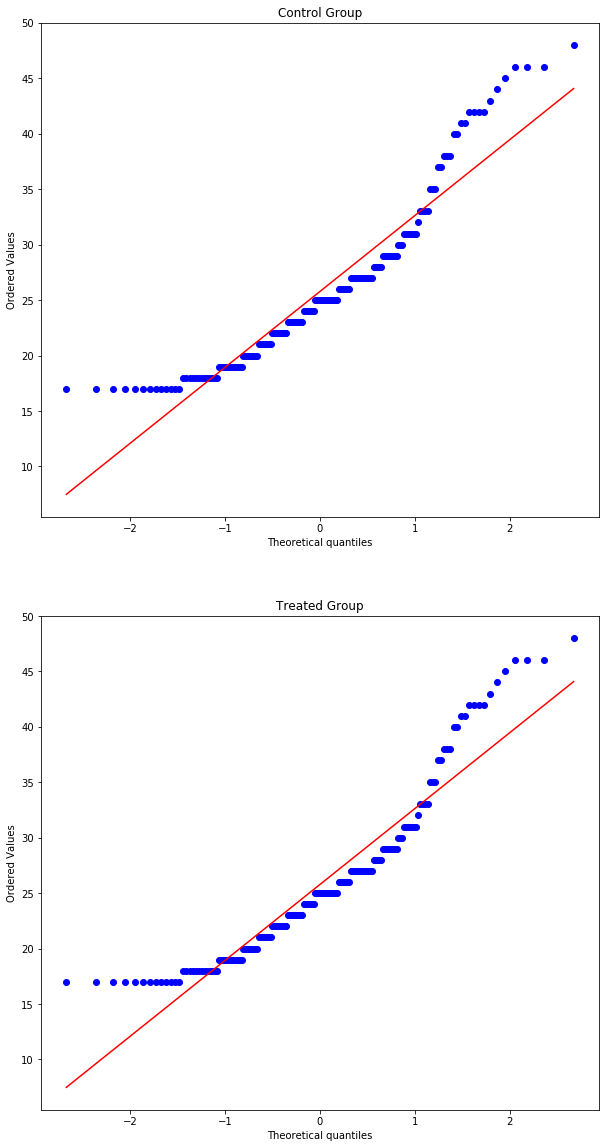


Control group
count    184.000000
mean      25.777174
std        7.154755
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64
Treated group
count    184.000000
mean      25.777174
std        7.154755
min       17.000000
25%       20.000000
50%       25.000000
75%       29.000000
max       48.000000
Name: age, dtype: float64

Ttest_indResult(statistic=0.0, pvalue=1.0)


                                   educ


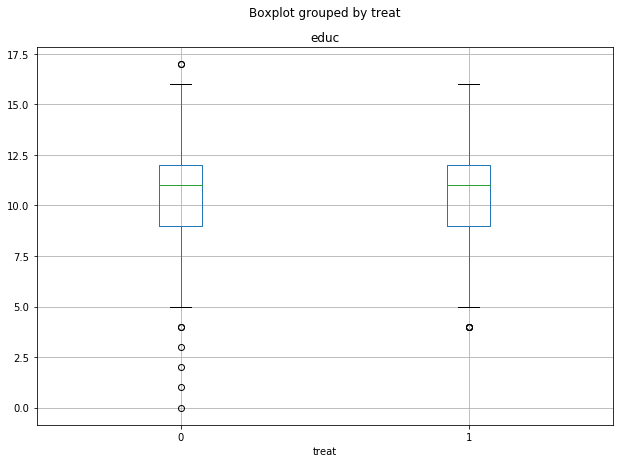

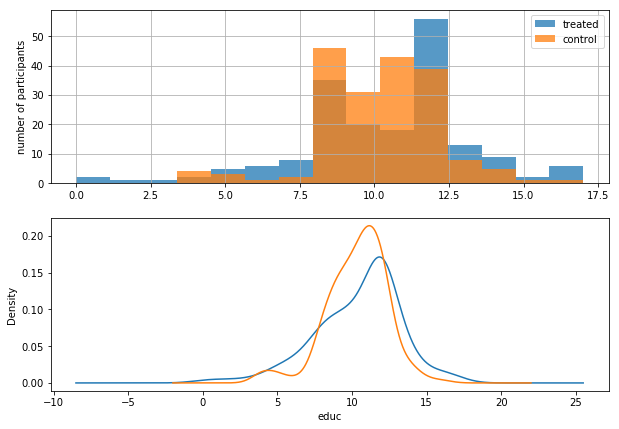

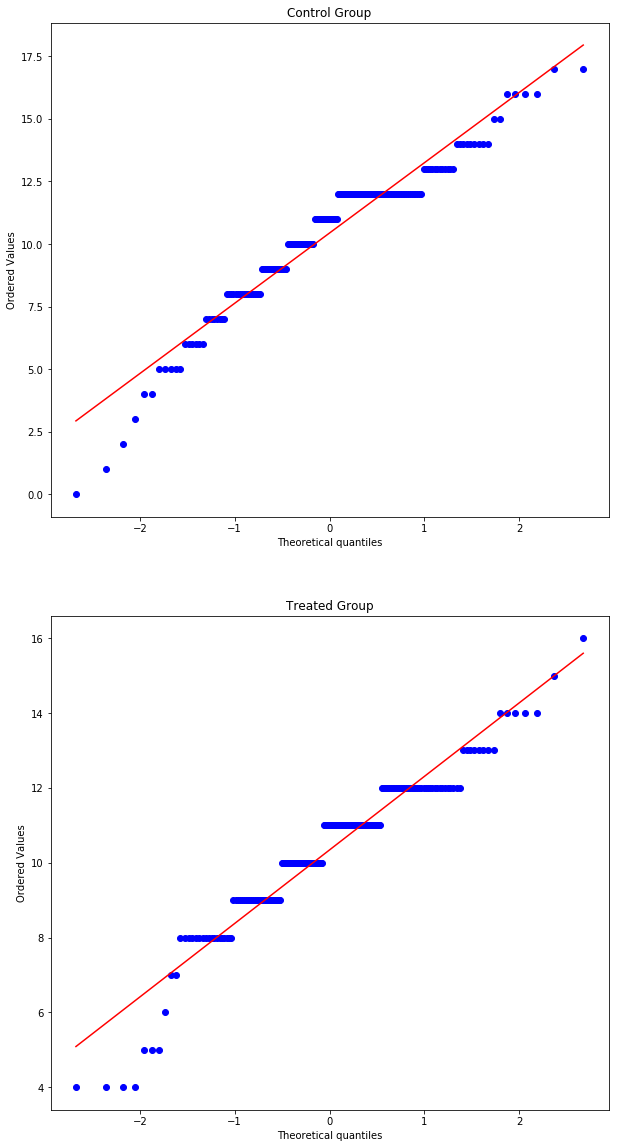


Control group
count    184.000000
mean      10.440217
std        2.869990
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64
Treated group
count    184.000000
mean      10.342391
std        2.015553
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64

Ttest_indResult(statistic=0.37837585186442901, pvalue=0.70537077435536133)


                                   re74


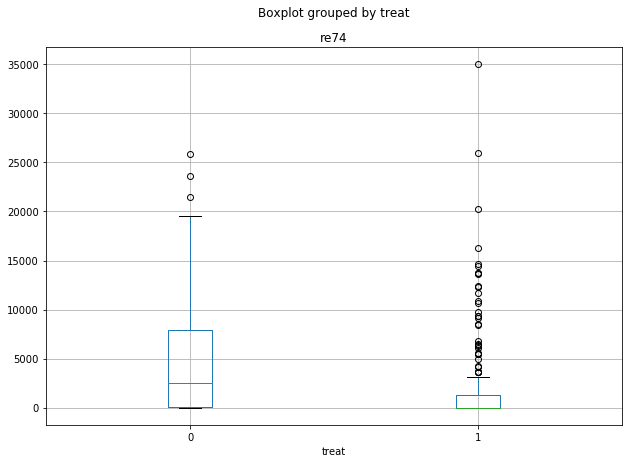

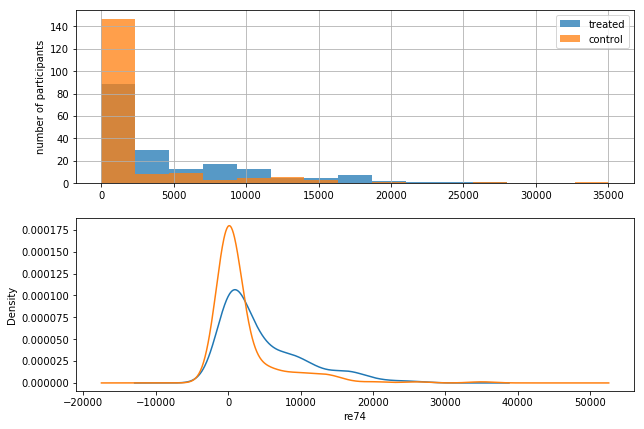

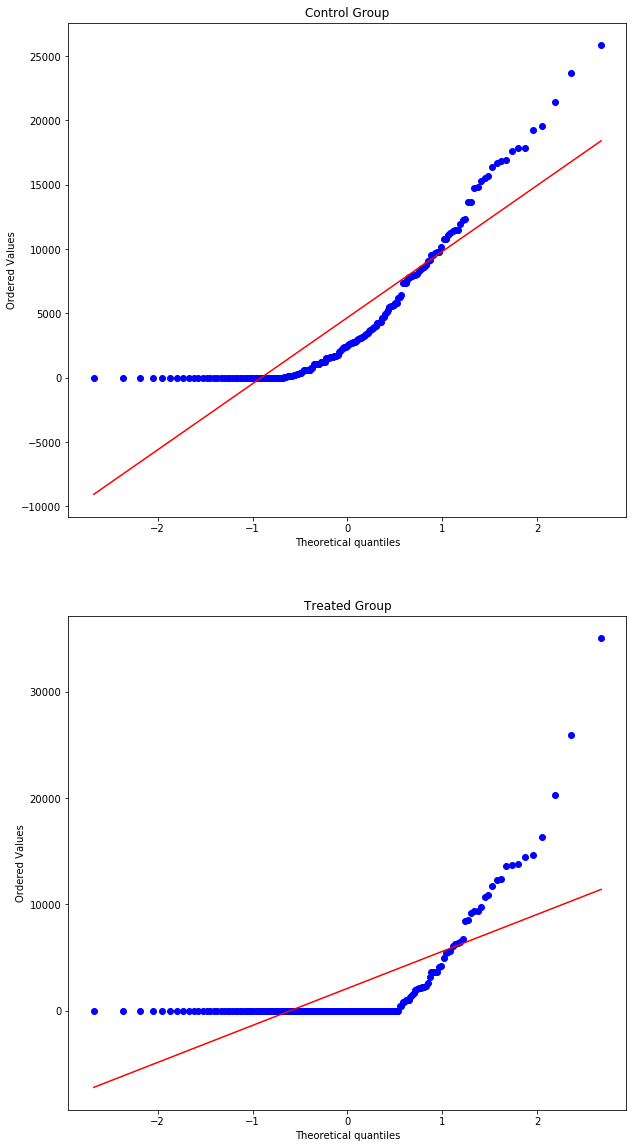


Control group
count      184.000000
mean      4669.805878
std       5659.775958
min          0.000000
25%         24.980655
50%       2495.126000
75%       7865.476750
max      25862.320000
Name: re74, dtype: float64
Treated group
count      184.000000
mean      2106.962676
std       4897.490974
min          0.000000
25%          0.000000
50%          0.000000
75%       1335.688000
max      35040.070000
Name: re74, dtype: float64

Ttest_indResult(statistic=4.6447814157192262, pvalue=4.7548039846978169e-06)


                                   re75


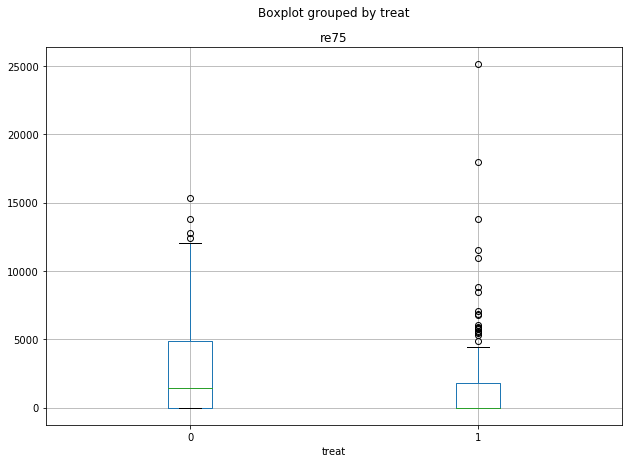

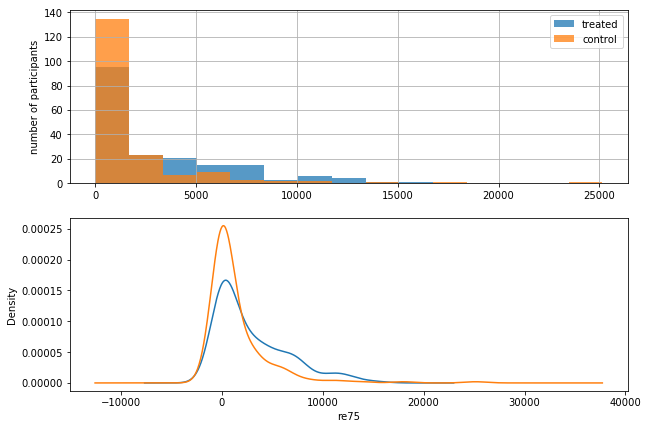

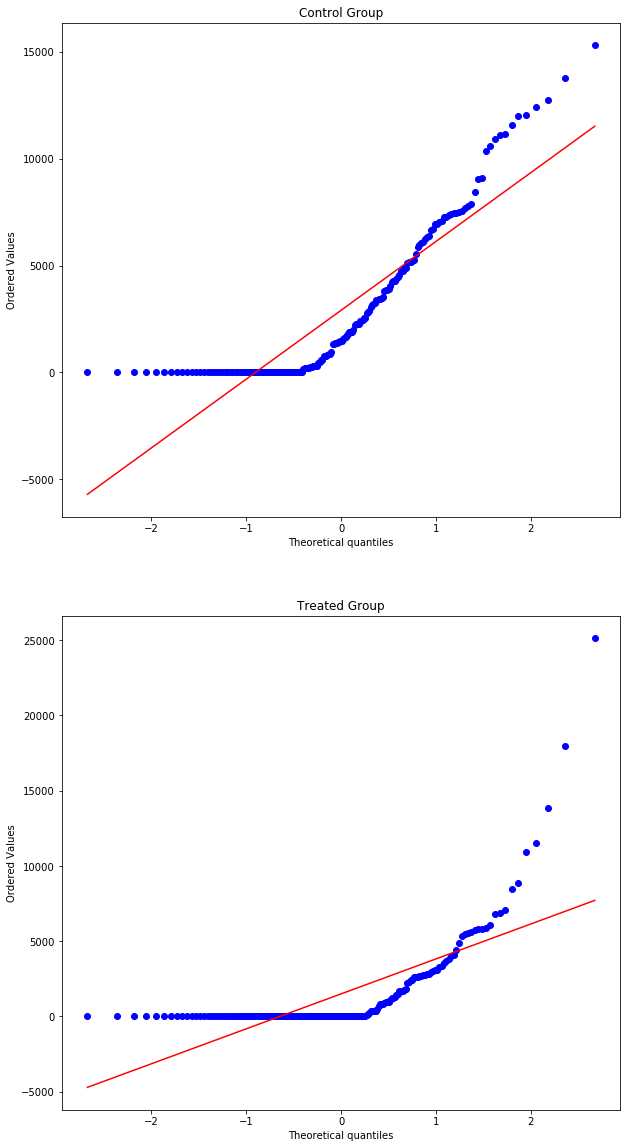


Control group
count      184.000000
mean      2909.877452
std       3534.979189
min          0.000000
25%          0.000000
50%       1466.274000
75%       4868.782500
max      15316.210000
Name: re75, dtype: float64
Treated group
count      184.000000
mean      1497.621288
std       3193.689743
min          0.000000
25%          0.000000
50%          0.000000
75%       1792.526500
max      25142.240000
Name: re75, dtype: float64

Ttest_indResult(statistic=4.0211501753298808, pvalue=7.0360597393426933e-05)


                                   re78


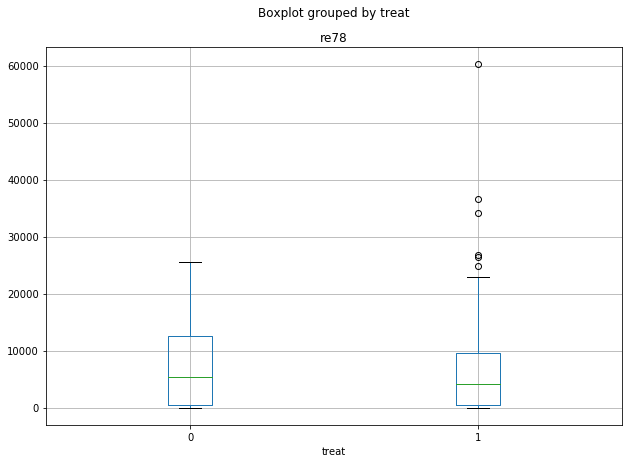

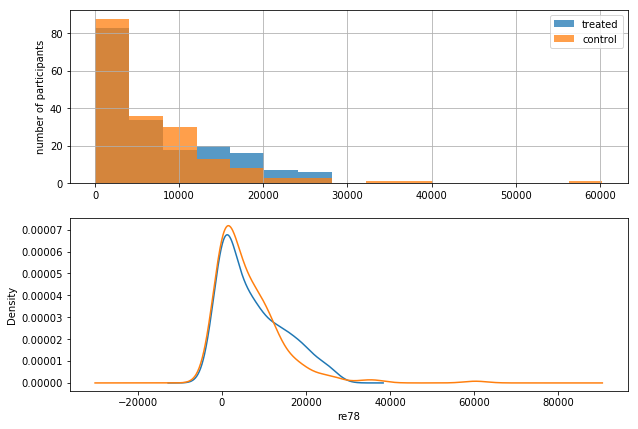

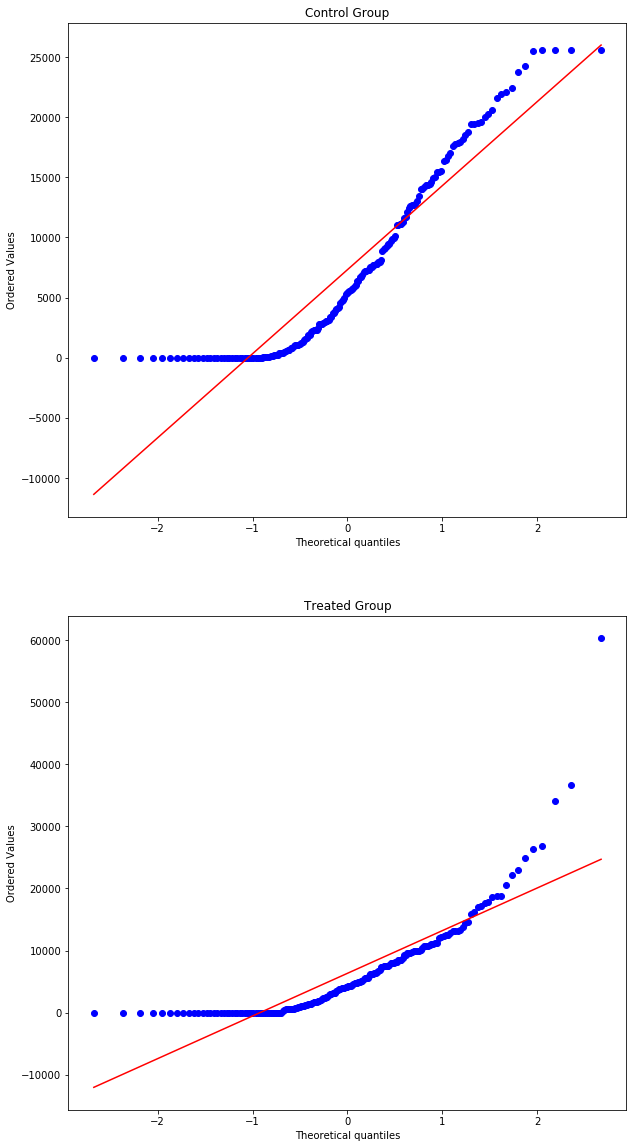


Control group
count      184.000000
mean      7322.681156
std       7385.283564
min          0.000000
25%        451.445475
50%       5420.301000
75%      12621.265000
max      25564.670000
Name: re78, dtype: float64
Treated group
count      184.000000
mean      6349.511522
std       7888.866970
min          0.000000
25%        436.369825
50%       4207.125500
75%       9666.537750
max      60307.930000
Name: re78, dtype: float64

Ttest_indResult(statistic=1.2215731588031058, pvalue=0.22265532072973837)




In [27]:
for col in ['age', 'educ', 're74', 're75', 're78']:
    analyse_numeric(lalonde_data_balanced, col)

                                   married


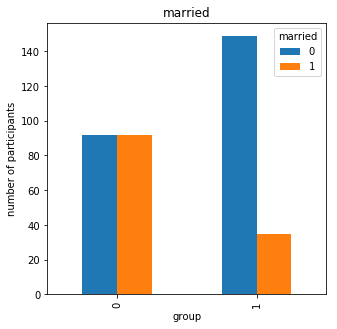


Control group
count    184.000000
mean       0.500000
std        0.501364
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: married, dtype: float64
Treated group
count    184.000000
mean       0.190217
std        0.393543
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: married, dtype: float64

Fisher exact test
(4.2571428571428571, 5.0228977679736634e-10)


                                   nodegree


/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


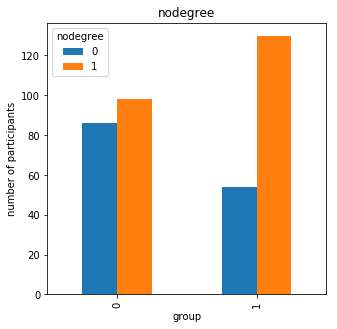


Control group
count    184.000000
mean       0.532609
std        0.500297
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64
Treated group
count    184.000000
mean       0.706522
std        0.456598
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nodegree, dtype: float64

Fisher exact test
(0.47334525939177102, 0.00084347256561048385)


                                   None


/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


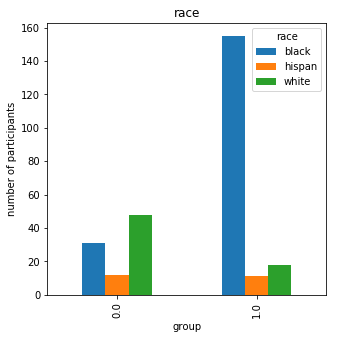

In [28]:
for col in ['married', 'nodegree']: 
    analyse_categoric(lalonde_data_balanced, col)

analyse_categoric(lalonde_data_balanced)

In [29]:
#todo add test for categoric

## 6. A less naive analysis

Remark that sensitivity analysis would be good!!

In [31]:
#analyse_numeric(..., 're78')